In [2]:
import mysql.connector as mysql
import pandas as pd
import folium
import requests
import googlemaps
from geopy.distance import geodesic
import numpy as np
from tqdm import tqdm
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from matplotlib import font_manager
from matplotlib import rc

#database-1.c9ks828mszs7.ap-northeast-2.rds.amazonaws.com

In [3]:
remote = mysql.connect (
    host = "database-1.c9ks828mszs7.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "roschool",
    password = "1234",
    database = "roschool"
)

In [4]:
cursor = remote.cursor(buffered=True)

sql = """
        WITH year_groups AS (
    SELECT 
        CASE 
            WHEN ci.years BETWEEN 0 AND 5 THEN '0-5years'
            WHEN ci.years BETWEEN 6 AND 10 THEN '6-10years'
            WHEN ci.years BETWEEN 11 AND 15 THEN '11-15years'
            WHEN ci.years BETWEEN 16 AND 20 THEN '16-20years'
            ELSE '20+years'
        END AS year_range,
        et.tech_id
    FROM 
        company_info ci
    JOIN recruit_info ri ON ci.comp_id = ri.comp_name_id
    JOIN essential_tech et ON ri.recruit_id = et.recruit_id
    WHERE 
        ci.years > 0
),
tech_counts AS (
    SELECT 
        yg.year_range,
        ti.tech_name,
        COUNT(*) AS tech_count
    FROM 
        year_groups yg
    JOIN tech_info ti ON yg.tech_id = ti.tech_id
    GROUP BY 
        yg.year_range, ti.tech_name
),
ranked_techs AS (
    SELECT 
        year_range,
        tech_name,
        tech_count,
        RANK() OVER (PARTITION BY year_range ORDER BY tech_count DESC) AS r
    FROM 
        tech_counts
)
SELECT 
    year_range,
    tech_name,
    tech_count
FROM 
    ranked_techs
WHERE 
    r <= 3
ORDER BY 
    year_range, tech_count DESC;

"""

cursor.execute(sql)
result = cursor.fetchall()

df = pd.DataFrame(result)

df

,0,1,2
0,0-5years,Embedded,4
1,0-5years,RTOS,3
2,0-5years,C++,3
3,0-5years,Python,3
4,11-15years,C,3
5,11-15years,Embedded,2
6,11-15years,C++,2
7,16-20years,C++,6
8,16-20years,C,5
9,16-20years,Linux,3


In [5]:
df.columns = ["업력", "기술", "수"]

In [14]:
df

,업력,기술,수
0,0-5years,Embedded,4
1,0-5years,RTOS,3
2,0-5years,C++,3
3,0-5years,Python,3
4,11-15years,C,3
5,11-15years,Embedded,2
6,11-15years,C++,2
7,16-20years,C++,6
8,16-20years,C,5
9,16-20years,Linux,3


In [6]:
# 업력 정렬 순서 설정
order = ["0-5years", "6-10years", "11-15years", "16-20years", "20+years"]
df["업력"] = pd.Categorical(df["업력"], categories=order, ordered=True)

# DataFrame 정렬
df = df.sort_values(by=["업력"]).reset_index(drop=True)

# 정렬된 DataFrame 출력
print(df)

            업력        기술  수
0     0-5years  Embedded  4
1     0-5years      RTOS  3
2     0-5years       C++  3
3     0-5years    Python  3
4    6-10years       C++  9
5    6-10years        C#  7
6    6-10years    Python  5
7   11-15years         C  3
8   11-15years  Embedded  2
9   11-15years       C++  2
10  16-20years       C++  6
11  16-20years         C  5
12  16-20years     Linux  3
13    20+years       C++  6
14    20+years    Python  6
15    20+years         C  5


/tmp/ipykernel_30679/4027611121.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("업력")


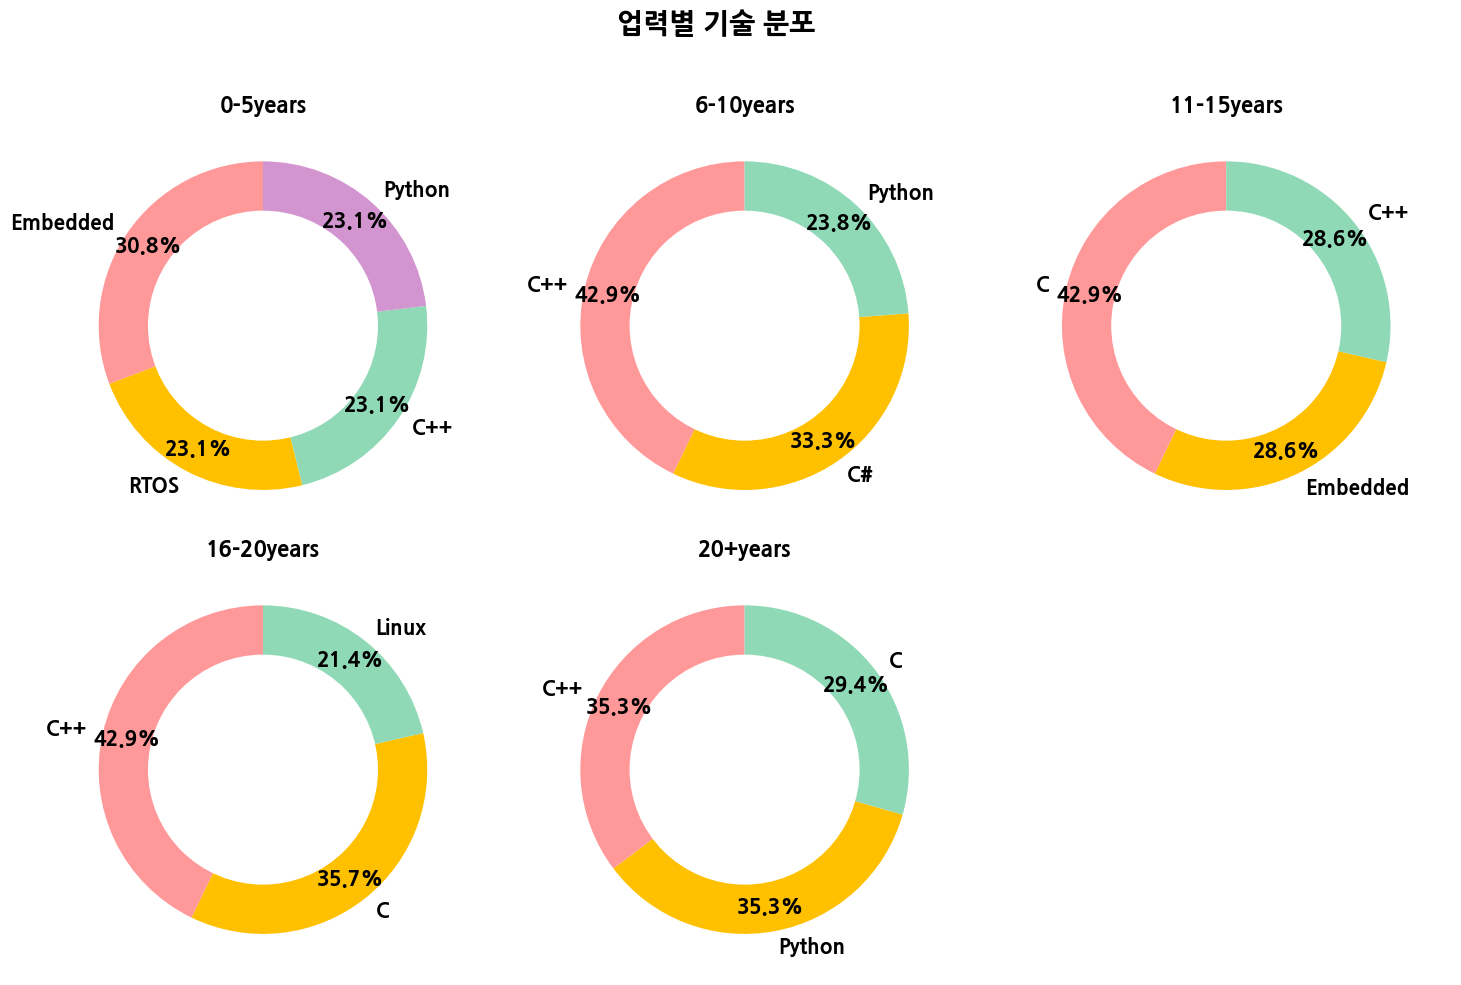

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 업력별 서브 도넛 파이차트 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("업력별 기술 분포", fontsize=20, fontweight='bold')  # 제목 글씨 크기와 볼드체 적용
axes = axes.flatten()

# 업력별 데이터 그룹화
grouped = df.groupby("업력")

for i, (key, group) in enumerate(grouped):
    labels = group["기술"]
    sizes = group["수"]
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#2E7B26'][:len(labels)]  # 색상 설정

    # 도넛 파이 차트
    wedges, texts, autotexts = axes[i].pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    axes[i].add_artist(centre_circle)
    axes[i].set_title(key, fontsize=16, fontweight='bold')  # 각 서브플롯 제목 글씨 크기와 볼드체 적용

    # 라벨과 퍼센트 글씨 크기 조정
    for text in texts:
        text.set_fontsize(15)  # 라벨 글씨 크기
        text.set_fontweight("bold")
    for autotext in autotexts:
        autotext.set_fontsize(15)  # 퍼센트 글씨 크기
        autotext.set_fontweight("bold")

# 나머지 빈 서브플롯 숨기기
for j in range(len(grouped), len(axes)):
    axes[j].axis('off')

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
